In [14]:
import h5py
import pandas as pd
import tensorflow as tf
import numpy as np
import lightgbm
import re
import umap
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.ensemble import RandomForestClassifier

In [15]:
def add_labels_to_excel(filename, sheet_name=2):
    df = pd.read_excel(filename, sheet_name=sheet_name)
    labels = []
    for file in df['file']:
        label = re.search("squeal|whinnie|softsnort|snort", file)
        if label:
            label = label.group(0)
            if label == "squeal":
                labels.append("squeal")
            elif label == "whinnie":
                labels.append("whinnie")
            elif label == 'snort':
                labels.append("snort")
            elif label == 'softsnort':
                labels.append("softsnort")
    df['label'] = labels
    return df

def split_dataset(X, y, test_total_ratio, val_train_ratio):
    X_train_temp, X_test, y_train_temp, y_test = train_test_split(X, y, test_size=test_total_ratio, random_state=0, shuffle=True)
    X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=val_train_ratio, random_state=0, shuffle=True)
    return X_train, y_train, X_val, y_val, X_test, y_test

def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    # plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0,10])
    plt.xlabel('Epoch')
    plt.ylabel('Error (Loss)')
    plt.legend()
    plt.grid(True)

In [16]:
directory_file = r"./Zebras_Assumption_data.xlsx"
df = add_labels_to_excel(directory_file)

X = df[df.columns.drop('file').drop('label')]
y = df['label']

#%% Split into training, testing, and validation(optional) sets
# Fractions must add up to 1.0
train_frac = 0.70
val_frac = 0.00
test_frac = 0.30

# If we dont need a validation set
if val_frac == 0:
    val_present = False
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_frac, random_state=0, shuffle=True)
# If we need a validation set
else:
    val_present = True
    X_train, y_train, X_val, y_val, X_test, y_test = split_dataset(X, y, test_frac, val_frac/(train_frac + val_frac))


In [17]:
# Feature importance
lgbm_model = lightgbm.LGBMClassifier()

if val_present == True:
    lgbm_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], verbose=20, eval_metric='logloss')
else:
    lgbm_model.fit(X_train, y_train, eval_set=[(X_train, y_train)], verbose=20, eval_metric='logloss')
print(lgbm_model.feature_importances_)
feature_importance = lgbm_model.feature_importances_

total = 0
for i in feature_importance:
    total += i
average = total / len(feature_importance)

feature_importance_series = pd.Series(feature_importance, index=X_train.columns)
impt_features_list = feature_importance_series[feature_importance >= average].index
X_train = X_train[impt_features_list]
X_test = X_test[impt_features_list]
if val_present:
    X_val = X_val[impt_features_list]

[20]	training's multi_logloss: 0.13769
[40]	training's multi_logloss: 0.0260983
[60]	training's multi_logloss: 0.0044881
[80]	training's multi_logloss: 0.000856258
[100]	training's multi_logloss: 0.000164422
[608 423 542 841 875 710 485 643 737]


In [18]:
# SCALING
X_scaler = StandardScaler()

# Fit on Training Data
X_scaler.fit(X_train.values)

# Transform Training, Validation and Testing data
X_train = X_scaler.transform(X_train.values)
X_test = X_scaler.transform(X_test.values)

lb = LabelEncoder()

y_train = lb.fit_transform(y_train)
y_test = lb.fit_transform(y_test)

if val_present:
    X_val = X_scaler.transform(X_val.values)
    y_group_val = lb.fit_transform(y_val)

In [25]:
nn_clf = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(4,)),
    tf.keras.layers.Dense(10,activation="relu"),
    tf.keras.layers.Dense(8,activation="relu"),
    tf.keras.layers.Dense(10,activation="softmax")
])

nn_clf.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
              optimizer=tf.keras.optimizers.SGD(), 
              metrics=['accuracy'])

nn_clf.fit(X_train, y_train, epochs=1000, batch_size=128)

Epoch 1/1000
3/3 [==============================] - 0s 3ms/step - loss: 2.2924 - accuracy: 0.0138
Epoch 2/1000
3/3 [==============================] - 0s 3ms/step - loss: 2.2742 - accuracy: 0.0138
Epoch 3/1000
3/3 [==============================] - 0s 3ms/step - loss: 2.2564 - accuracy: 0.0138
Epoch 4/1000
3/3 [==============================] - 0s 4ms/step - loss: 2.2390 - accuracy: 0.0173
Epoch 5/1000
3/3 [==============================] - 0s 4ms/step - loss: 2.2215 - accuracy: 0.0277
Epoch 6/1000
3/3 [==============================] - 0s 4ms/step - loss: 2.2037 - accuracy: 0.0311
Epoch 7/1000
3/3 [==============================] - 0s 4ms/step - loss: 2.1864 - accuracy: 0.0450
Epoch 8/1000
3/3 [==============================] - 0s 3ms/step - loss: 2.1699 - accuracy: 0.0623
Epoch 9/1000
3/3 [==============================] - 0s 4ms/step - loss: 2.1525 - accuracy: 0.0761
Epoch 10/1000
3/3 [==============================] - 0s 3ms/step - loss: 2.1355 - accuracy: 0.0969
Epoch 11/1000
3/3 [

3/3 [==============================] - 0s 2ms/step - loss: 0.5564 - accuracy: 0.8720
Epoch 166/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.5540 - accuracy: 0.8720
Epoch 167/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.5519 - accuracy: 0.8720
Epoch 168/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.5497 - accuracy: 0.8720
Epoch 169/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.5479 - accuracy: 0.8720
Epoch 170/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.5460 - accuracy: 0.8720
Epoch 171/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.5440 - accuracy: 0.8720
Epoch 172/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.5422 - accuracy: 0.8720
Epoch 173/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.5402 - accuracy: 0.8720
Epoch 174/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.5383 - accuracy: 0.8720
Epoch 175/1000


3/3 [==============================] - 0s 3ms/step - loss: 0.4504 - accuracy: 0.8720
Epoch 248/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.4496 - accuracy: 0.8720
Epoch 249/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.4488 - accuracy: 0.8720
Epoch 250/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.4482 - accuracy: 0.8720
Epoch 251/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.4472 - accuracy: 0.8720
Epoch 252/1000
3/3 [==============================] - 0s 3ms/step - loss: 0.4463 - accuracy: 0.8720
Epoch 253/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.4455 - accuracy: 0.8720
Epoch 254/1000
3/3 [==============================] - 0s 1ms/step - loss: 0.4447 - accuracy: 0.8720
Epoch 255/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.4439 - accuracy: 0.8720
Epoch 256/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.4432 - accuracy: 0.8720
Epoch 257/1000


3/3 [==============================] - 0s 2ms/step - loss: 0.4033 - accuracy: 0.8754
Epoch 330/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.4029 - accuracy: 0.8754
Epoch 331/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.4025 - accuracy: 0.8754
Epoch 332/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.4020 - accuracy: 0.8754
Epoch 333/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.4016 - accuracy: 0.8754
Epoch 334/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.4012 - accuracy: 0.8754
Epoch 335/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.4009 - accuracy: 0.8754
Epoch 336/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.4005 - accuracy: 0.8754
Epoch 337/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.4001 - accuracy: 0.8754
Epoch 338/1000
3/3 [==============================] - 0s 1ms/step - loss: 0.3996 - accuracy: 0.8754
Epoch 339/1000


3/3 [==============================] - 0s 2ms/step - loss: 0.3755 - accuracy: 0.8824
Epoch 412/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.3752 - accuracy: 0.8824
Epoch 413/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.3750 - accuracy: 0.8824
Epoch 414/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.3747 - accuracy: 0.8824
Epoch 415/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.3744 - accuracy: 0.8824
Epoch 416/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.3741 - accuracy: 0.8789
Epoch 417/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.3739 - accuracy: 0.8789
Epoch 418/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.3736 - accuracy: 0.8789
Epoch 419/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.3733 - accuracy: 0.8824
Epoch 420/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.3730 - accuracy: 0.8824
Epoch 421/1000


3/3 [==============================] - 0s 2ms/step - loss: 0.3573 - accuracy: 0.8893
Epoch 494/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.3571 - accuracy: 0.8893
Epoch 495/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.3569 - accuracy: 0.8893
Epoch 496/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.3568 - accuracy: 0.8893
Epoch 497/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.3566 - accuracy: 0.8893
Epoch 498/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.3565 - accuracy: 0.8893
Epoch 499/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.3562 - accuracy: 0.8893
Epoch 500/1000
3/3 [==============================] - 0s 1ms/step - loss: 0.3560 - accuracy: 0.8893
Epoch 501/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.3558 - accuracy: 0.8893
Epoch 502/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.3556 - accuracy: 0.8927
Epoch 503/1000


3/3 [==============================] - 0s 2ms/step - loss: 0.3426 - accuracy: 0.8997
Epoch 576/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.3424 - accuracy: 0.8997
Epoch 577/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.3423 - accuracy: 0.8997
Epoch 578/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.3422 - accuracy: 0.8997
Epoch 579/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.3420 - accuracy: 0.8997
Epoch 580/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.3418 - accuracy: 0.8997
Epoch 581/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.3417 - accuracy: 0.8997
Epoch 582/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.3416 - accuracy: 0.8997
Epoch 583/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.3413 - accuracy: 0.8997
Epoch 584/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.3411 - accuracy: 0.8997
Epoch 585/1000


Epoch 657/1000
3/3 [==============================] - 0s 980us/step - loss: 0.3304 - accuracy: 0.9031
Epoch 658/1000
3/3 [==============================] - 0s 969us/step - loss: 0.3304 - accuracy: 0.9031
Epoch 659/1000
3/3 [==============================] - 0s 1ms/step - loss: 0.3303 - accuracy: 0.9031
Epoch 660/1000
3/3 [==============================] - 0s 1ms/step - loss: 0.3301 - accuracy: 0.9066
Epoch 661/1000
3/3 [==============================] - 0s 1ms/step - loss: 0.3301 - accuracy: 0.9066
Epoch 662/1000
3/3 [==============================] - 0s 999us/step - loss: 0.3299 - accuracy: 0.9031
Epoch 663/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.3298 - accuracy: 0.9066
Epoch 664/1000
3/3 [==============================] - 0s 997us/step - loss: 0.3296 - accuracy: 0.9066
Epoch 665/1000
3/3 [==============================] - 0s 1ms/step - loss: 0.3295 - accuracy: 0.9066
Epoch 666/1000
3/3 [==============================] - 0s 997us/step - loss: 0.3293 - accurac

3/3 [==============================] - 0s 1ms/step - loss: 0.3144 - accuracy: 0.9170
Epoch 821/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.3143 - accuracy: 0.9170
Epoch 822/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.3145 - accuracy: 0.9170
Epoch 823/1000
3/3 [==============================] - 0s 1ms/step - loss: 0.3141 - accuracy: 0.9170
Epoch 824/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.3140 - accuracy: 0.9170
Epoch 825/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.3141 - accuracy: 0.9170
Epoch 826/1000
3/3 [==============================] - 0s 3ms/step - loss: 0.3139 - accuracy: 0.9170
Epoch 827/1000
3/3 [==============================] - 0s 998us/step - loss: 0.3140 - accuracy: 0.9170
Epoch 828/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.3138 - accuracy: 0.9170
Epoch 829/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.3137 - accuracy: 0.9170
Epoch 830/100

3/3 [==============================] - 0s 2ms/step - loss: 0.3087 - accuracy: 0.9170
Epoch 903/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.3088 - accuracy: 0.9170
Epoch 904/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.3087 - accuracy: 0.9170
Epoch 905/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.3087 - accuracy: 0.9170
Epoch 906/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.3085 - accuracy: 0.9170
Epoch 907/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.3084 - accuracy: 0.9170
Epoch 908/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.3085 - accuracy: 0.9170
Epoch 909/1000
3/3 [==============================] - 0s 3ms/step - loss: 0.3083 - accuracy: 0.9170
Epoch 910/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.3084 - accuracy: 0.9170
Epoch 911/1000
3/3 [==============================] - 0s 1ms/step - loss: 0.3082 - accuracy: 0.9170
Epoch 912/1000


3/3 [==============================] - 0s 2ms/step - loss: 0.3040 - accuracy: 0.9170
Epoch 985/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.3040 - accuracy: 0.9170
Epoch 986/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.3039 - accuracy: 0.9170
Epoch 987/1000
3/3 [==============================] - 0s 3ms/step - loss: 0.3038 - accuracy: 0.9170
Epoch 988/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.3038 - accuracy: 0.9170
Epoch 989/1000
3/3 [==============================] - 0s 3ms/step - loss: 0.3037 - accuracy: 0.9170
Epoch 990/1000
3/3 [==============================] - 0s 3ms/step - loss: 0.3036 - accuracy: 0.9170
Epoch 991/1000
3/3 [==============================] - 0s 3ms/step - loss: 0.3036 - accuracy: 0.9170
Epoch 992/1000
3/3 [==============================] - 0s 3ms/step - loss: 0.3034 - accuracy: 0.9170
Epoch 993/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.3034 - accuracy: 0.9170
Epoch 994/1000


In [26]:
y_pred_proba = nn_clf.predict(X_test)

y_pred = []
for proba in y_pred_proba:
    highest_group = proba.argmax()
    y_pred.append(highest_group)

[[66  0  0  2]
 [ 3  0  0  0]
 [ 9  1  5  0]
 [ 0  0  0 38]]


[Text(0, 0.5, 'snort'),
 Text(0, 1.5, 'softsnort'),
 Text(0, 2.5, 'squeal'),
 Text(0, 3.5, 'whinnie')]

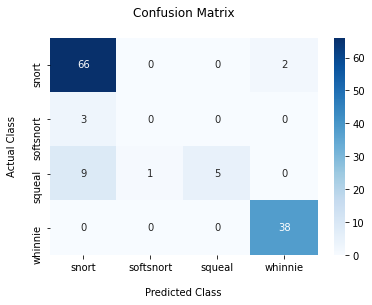

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')
ax.set_title('Confusion Matrix\n')
ax.set_xlabel('\nPredicted Class')
ax.set_ylabel('Actual Class\n')
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['snort','softsnort', 'squeal', 'whinnie'])
ax.yaxis.set_ticklabels(['snort','softsnort', 'squeal', 'whinnie'])